In [1]:
import csv
import pandas as pd
import requests
import os
from collections import defaultdict
from datetime import timedelta
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas
import matplotlib

/home/gautam/.local/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
pixel = geopandas.read_file("zip://../dataset/Hi.zip")
pixel

,ID,geometry
0,1,"POLYGON ((750000.000 520000.000, 751000.000 52..."
1,2,"POLYGON ((751000.000 520000.000, 752000.000 52..."
2,3,"POLYGON ((752000.000 520000.000, 753000.000 52..."
3,4,"POLYGON ((753000.000 520000.000, 754000.000 52..."
4,5,"POLYGON ((754000.000 520000.000, 755000.000 52..."
...,...,...
7695,7696,"POLYGON ((855000.000 451000.000, 856000.000 45..."
7696,7697,"POLYGON ((856000.000 451000.000, 857000.000 45..."
7697,7698,"POLYGON ((857000.000 451000.000, 858000.000 45..."
7698,7699,"POLYGON ((858000.000 451000.000, 859000.000 45..."


In [3]:
one = geopandas.read_file("../dataset/1yr_prediction")
one=one[["geometry","prediction","pvmt_ratin"]]
one

,geometry,prediction,pvmt_ratin
0,"LINESTRING (839120.367 491947.125, 839128.216 ...",8.972000e-12,NaN
1,"LINESTRING (805899.264 468237.072, 806078.398 ...",1.131859e-03,NaN
2,"LINESTRING (817263.913 468292.796, 817376.537 ...",3.063407e-02,NaN
3,"LINESTRING (812586.155 468311.223, 812907.967 ...",5.913109e-05,NaN
4,"LINESTRING (806832.776 474127.089, 806866.785 ...",3.661825e-01,5.0
...,...,...,...
10216,"LINESTRING (782138.210 468960.585, 781406.573 ...",5.466866e-02,NaN
10217,"LINESTRING (782148.645 469701.925, 782138.210 ...",5.466866e-02,NaN
10218,"LINESTRING (782138.210 468960.585, 782150.621 ...",5.466866e-02,NaN
10219,"LINESTRING (789389.038 465926.289, 789227.525 ...",5.466866e-02,7.0


In [4]:
one_pixel = geopandas.sjoin(pixel, one, how="inner", op='intersects')
one_pixel=one_pixel[["geometry","prediction"]]
one_pixel["index"]=one_pixel.index
one_pixel=one_pixel.groupby(by='index').agg({'prediction': 'max','geometry':'first'}).reset_index()
one_pixel=one_pixel[["geometry","prediction"]]
one_pixel=geopandas.GeoDataFrame(one_pixel)
one_pixel

/home/gautam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:8193

  """Entry point for launching an IPython kernel.


,geometry,prediction
0,"POLYGON ((837000.000 519000.000, 838000.000 51...",0.054669
1,"POLYGON ((839000.000 519000.000, 840000.000 51...",0.054669
2,"POLYGON ((840000.000 519000.000, 841000.000 51...",0.054669
3,"POLYGON ((841000.000 519000.000, 842000.000 51...",0.054669
4,"POLYGON ((842000.000 519000.000, 843000.000 51...",0.054669
...,...,...
2129,"POLYGON ((790000.000 457000.000, 791000.000 45...",0.054669
2130,"POLYGON ((791000.000 457000.000, 792000.000 45...",0.054669
2131,"POLYGON ((792000.000 457000.000, 793000.000 45...",0.054669
2132,"POLYGON ((789000.000 456000.000, 790000.000 45...",0.054669


In [5]:
five = geopandas.read_file("../dataset/5yr_prediction")
five=five[["geometry","prediction","pvmt_ratin"]]
five

,geometry,prediction,pvmt_ratin
0,"LINESTRING (839120.367 491947.125, 839128.216 ...",0.082593,NaN
1,"LINESTRING (805899.264 468237.072, 806078.398 ...",0.259088,NaN
2,"LINESTRING (817263.913 468292.796, 817376.537 ...",0.381232,NaN
3,"LINESTRING (812586.155 468311.223, 812907.967 ...",0.261788,NaN
4,"LINESTRING (806832.776 474127.089, 806866.785 ...",0.309893,5.0
...,...,...,...
10216,"LINESTRING (782138.210 468960.585, 781406.573 ...",0.068091,NaN
10217,"LINESTRING (782148.645 469701.925, 782138.210 ...",0.068091,NaN
10218,"LINESTRING (782138.210 468960.585, 782150.621 ...",0.068091,NaN
10219,"LINESTRING (789389.038 465926.289, 789227.525 ...",0.068091,7.0


In [6]:
five_pixel = geopandas.sjoin(pixel, five, how="inner", op='intersects')
five_pixel=five_pixel[["geometry","prediction"]]
five_pixel["index"]=five_pixel.index
five_pixel=five_pixel.groupby(by='index').agg({'prediction': 'max','geometry':'first'}).reset_index()
five_pixel=five_pixel[["geometry","prediction"]]
five_pixel=geopandas.GeoDataFrame(five_pixel)
five_pixel

/home/gautam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:8193

  """Entry point for launching an IPython kernel.


,geometry,prediction
0,"POLYGON ((837000.000 519000.000, 838000.000 51...",0.068091
1,"POLYGON ((839000.000 519000.000, 840000.000 51...",0.068091
2,"POLYGON ((840000.000 519000.000, 841000.000 51...",0.068091
3,"POLYGON ((841000.000 519000.000, 842000.000 51...",0.068091
4,"POLYGON ((842000.000 519000.000, 843000.000 51...",0.068091
...,...,...
2129,"POLYGON ((790000.000 457000.000, 791000.000 45...",0.287511
2130,"POLYGON ((791000.000 457000.000, 792000.000 45...",0.287511
2131,"POLYGON ((792000.000 457000.000, 793000.000 45...",0.068091
2132,"POLYGON ((789000.000 456000.000, 790000.000 45...",0.068091


In [7]:
ten = geopandas.read_file("../dataset/10yr_prediction")
ten=ten[["geometry","prediction","pvmt_ratin"]]
ten

,geometry,prediction,pvmt_ratin
0,"LINESTRING (839120.367 491947.125, 839128.216 ...",0.216477,NaN
1,"LINESTRING (805899.264 468237.072, 806078.398 ...",0.378009,NaN
2,"LINESTRING (817263.913 468292.796, 817376.537 ...",0.548636,NaN
3,"LINESTRING (812586.155 468311.223, 812907.967 ...",0.443005,NaN
4,"LINESTRING (806832.776 474127.089, 806866.785 ...",0.363717,5.0
...,...,...,...
10216,"LINESTRING (782138.210 468960.585, 781406.573 ...",0.091044,NaN
10217,"LINESTRING (782148.645 469701.925, 782138.210 ...",0.091044,NaN
10218,"LINESTRING (782138.210 468960.585, 782150.621 ...",0.091044,NaN
10219,"LINESTRING (789389.038 465926.289, 789227.525 ...",0.091044,7.0


In [8]:
ten_pixel = geopandas.sjoin(pixel, ten, how="inner", op='intersects')
ten_pixel=ten_pixel[["geometry","prediction"]]
ten_pixel["index"]=ten_pixel.index
ten_pixel=ten_pixel.groupby(by='index').agg({'prediction': 'max','geometry':'first'}).reset_index()
ten_pixel=ten_pixel[["geometry","prediction"]]
ten_pixel=geopandas.GeoDataFrame(ten_pixel)
ten_pixel

/home/gautam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:8193

  """Entry point for launching an IPython kernel.


,geometry,prediction
0,"POLYGON ((837000.000 519000.000, 838000.000 51...",0.091044
1,"POLYGON ((839000.000 519000.000, 840000.000 51...",0.091044
2,"POLYGON ((840000.000 519000.000, 841000.000 51...",0.091044
3,"POLYGON ((841000.000 519000.000, 842000.000 51...",0.091044
4,"POLYGON ((842000.000 519000.000, 843000.000 51...",0.091044
...,...,...
2129,"POLYGON ((790000.000 457000.000, 791000.000 45...",0.367858
2130,"POLYGON ((791000.000 457000.000, 792000.000 45...",0.367858
2131,"POLYGON ((792000.000 457000.000, 793000.000 45...",0.091044
2132,"POLYGON ((789000.000 456000.000, 790000.000 45...",0.091044


In [9]:
twenty = geopandas.read_file("../dataset/20yr_prediction")
twenty=twenty[["geometry","prediction","pvmt_ratin"]]
twenty

,geometry,prediction,pvmt_ratin
0,"LINESTRING (839120.367 491947.125, 839128.216 ...",0.601128,NaN
1,"LINESTRING (805899.264 468237.072, 806078.398 ...",0.956129,NaN
2,"LINESTRING (817263.913 468292.796, 817376.537 ...",0.978976,NaN
3,"LINESTRING (812586.155 468311.223, 812907.967 ...",0.946134,NaN
4,"LINESTRING (806832.776 474127.089, 806866.785 ...",0.930748,5.0
...,...,...,...
10216,"LINESTRING (782138.210 468960.585, 781406.573 ...",0.179740,NaN
10217,"LINESTRING (782148.645 469701.925, 782138.210 ...",0.179740,NaN
10218,"LINESTRING (782138.210 468960.585, 782150.621 ...",0.179740,NaN
10219,"LINESTRING (789389.038 465926.289, 789227.525 ...",0.179740,7.0


In [10]:
twenty_pixel = geopandas.sjoin(pixel, twenty, how="inner", op='intersects')
twenty_pixel=twenty_pixel[["geometry","prediction"]]
twenty_pixel["index"]=twenty_pixel.index
twenty_pixel=twenty_pixel.groupby(by='index').agg({'prediction': 'max','geometry':'first'}).reset_index()
twenty_pixel=twenty_pixel[["geometry","prediction"]]
twenty_pixel=geopandas.GeoDataFrame(twenty_pixel)
twenty_pixel

/home/gautam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:8193

  """Entry point for launching an IPython kernel.


,geometry,prediction
0,"POLYGON ((837000.000 519000.000, 838000.000 51...",0.179740
1,"POLYGON ((839000.000 519000.000, 840000.000 51...",0.179740
2,"POLYGON ((840000.000 519000.000, 841000.000 51...",0.179740
3,"POLYGON ((841000.000 519000.000, 842000.000 51...",0.179740
4,"POLYGON ((842000.000 519000.000, 843000.000 51...",0.179740
...,...,...
2129,"POLYGON ((790000.000 457000.000, 791000.000 45...",0.896407
2130,"POLYGON ((791000.000 457000.000, 792000.000 45...",0.896407
2131,"POLYGON ((792000.000 457000.000, 793000.000 45...",0.179740
2132,"POLYGON ((789000.000 456000.000, 790000.000 45...",0.179740


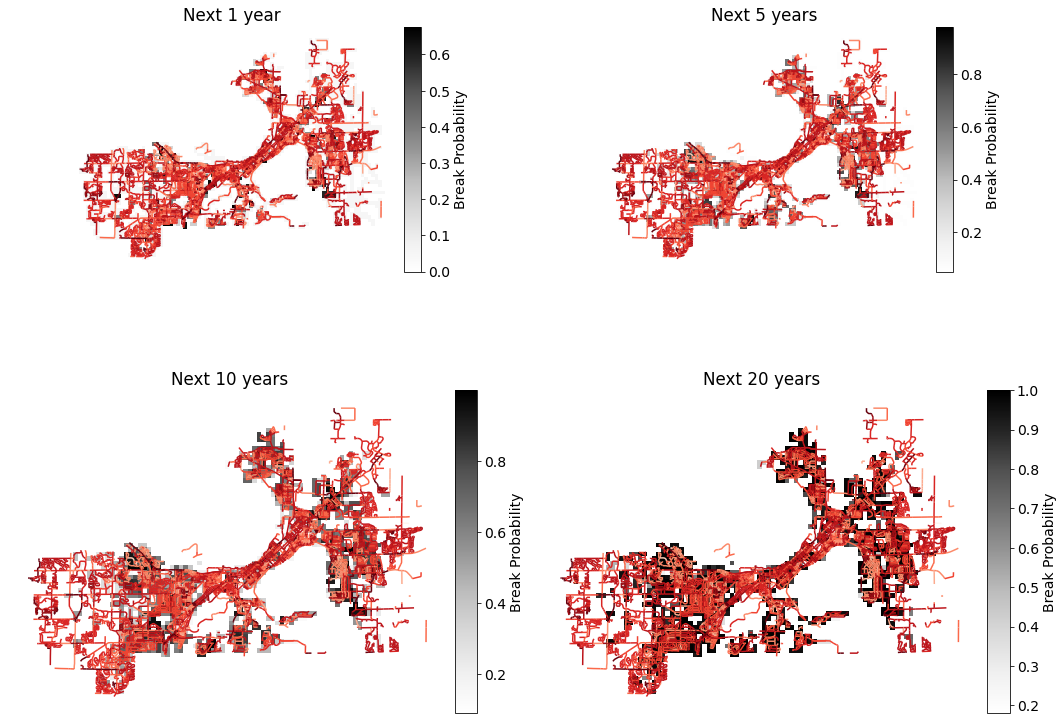

In [11]:
matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(15,15))
cx = fig.add_subplot(121)
dx = fig.add_subplot(122)
ax = fig.add_subplot(421)
bx = fig.add_subplot(422)

dividera = make_axes_locatable(ax)
cax = dividera.append_axes("right", size="5%", pad=0.05,label="Risk")

dividerb = make_axes_locatable(bx)
cbx = dividerb.append_axes("right", size="5%", pad=0.05,label="Risk")

dividerc = make_axes_locatable(cx)
ccx = dividerc.append_axes("right", size="5%", pad=0.05,label="Risk")

dividerd = make_axes_locatable(dx)
cdx = dividerd.append_axes("right", size="5%", pad=0.05,label="Risk")

one_pixel.plot(column="prediction",cmap="Greys",ax=ax,legend=True,cax=cax,legend_kwds={'label': "Break Probability"})
one.plot(column="pvmt_ratin",cmap="Reds",ax=ax)
ax.axis("off")
ax.set_title("Next 1 year")

five_pixel.plot(column="prediction",cmap="Greys",ax=bx,legend=True,cax=cbx,legend_kwds={'label': "Break Probability"})
five.plot(column="pvmt_ratin",cmap="Reds",ax=bx)
bx.axis("off")
bx.set_title("Next 5 years")

ten_pixel.plot(column="prediction",cmap="Greys",ax=cx,legend=True,cax=ccx,legend_kwds={'label': "Break Probability"})
ten.plot(column="pvmt_ratin",cmap="Reds",ax=cx)
cx.axis("off")
cx.set_title("Next 10 years")

twenty_pixel.plot(column="prediction",cmap="Greys",ax=dx,legend=True,cax=cdx,legend_kwds={'label': "Break Probability"})
twenty.plot(column="pvmt_ratin",cmap="Reds",ax=dx)
dx.axis("off")
dx.set_title("Next 20 years")

plt.tight_layout()
fig.show()
#plt.savefig('riskmap.pdf',format='pdf')